## Исследовательский анализ данных

In [1]:
!pip install tensorflow -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cpu 2.7.0 requires flatbuffers<3.0,>=1.12, but you have flatbuffers 24.3.25 which is incompatible.
tensorflow-cpu 2.7.0 requires keras<2.8,>=2.7.0rc0, but you have keras 3.3.3 which is incompatible.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-06-24 09:44:22.694170: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 09:44:22.695634: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 09:44:22.704572: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 09:44:22.778657: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-cri

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [5]:
labels.duplicated().sum()

0

Дубликатов в данных нет

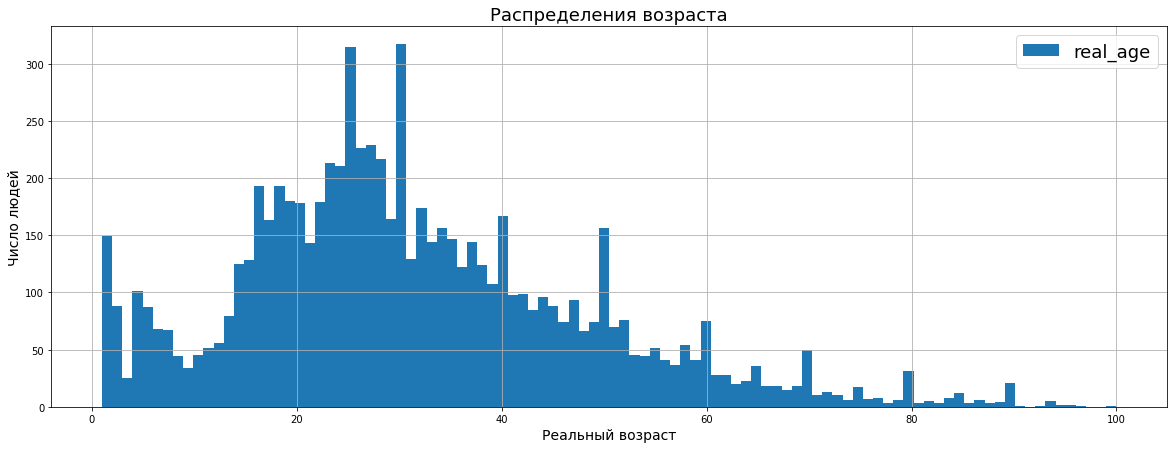

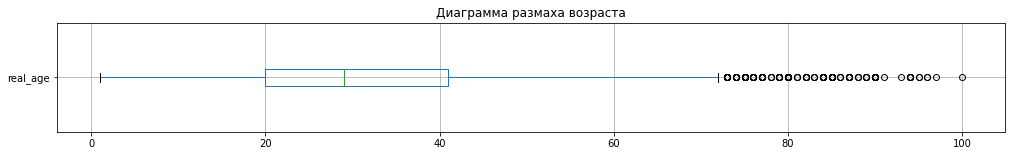

Статистика: count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


In [6]:
labels['real_age'].plot(kind = 'hist', bins = 100, figsize = (20, 7))
plt.title('Распределения возраста', fontsize = 18)
plt.xlabel('Реальный возраст', fontsize = 14)
plt.ylabel('Число людей', fontsize = 14)
plt.grid(True)
plt.legend(fontsize = 18)
plt.show();


fig, ax = plt.subplots(figsize = (17,2))
ax = labels[['real_age']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха возраста')
plt.show();

print('Статистика:', labels['real_age'].describe())

Обзор данных:

Таблица содержит 7591 объект и 2 признака: file_name (названия файлов) и целевой признак real_age (возраст).
Пропуски данных отсутствуют.
Статистические характеристики:

Средний медианный возраст составляет 29 лет.
Стандартное отклонение равно 17 годам.
Минимальный возраст — 1 год, максимальный — 100 лет.
Аномалии в данных не обнаружены.
Пик распределения возрастов приходится на интервал 25-30 лет.
Данные распределены неравномерно, поэтому для улучшения модели требуется аугментация данных, чтобы увеличить количество объектов в недопредставленных возрастных группах.

**Анализ изображений**

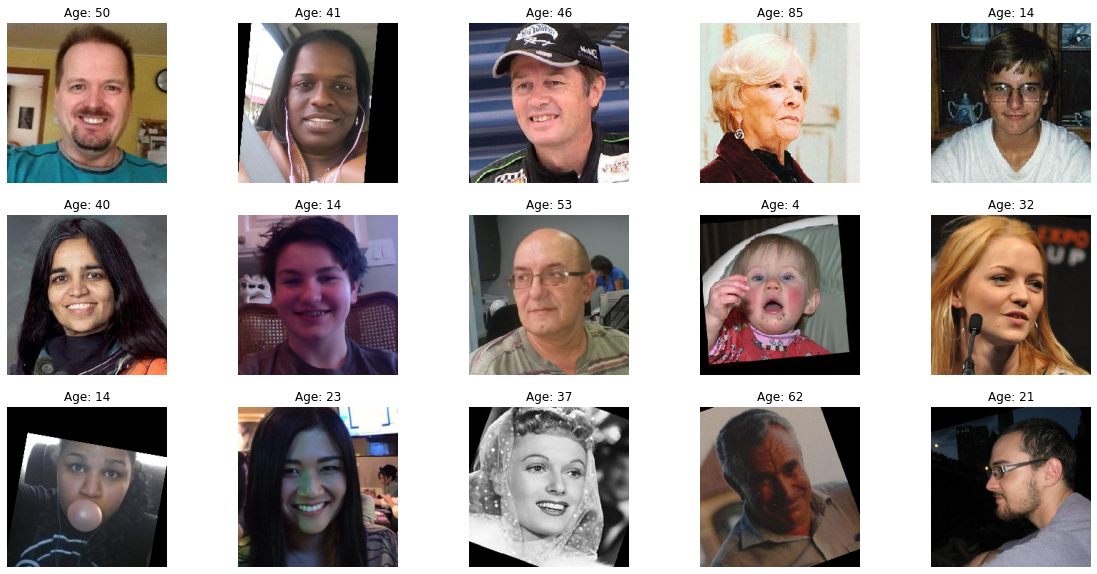

In [7]:
def show_images(generator, num_images=15):
    images, labels = next(generator)
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f'Age: {int(labels[i])}')
        plt.axis('off')
    plt.show()

show_images(train_gen_flow)

**Общие выводы:**
Фотографии размечены верно, изображения содержатся в файлах формата jpg, имеют три цветовых канала и разные размеры.

В данных присутсвует дисбаланс.Группа людей 20-30 лет встречается гораздо чаще чем дети или пожилые люди. Такое распределение может повлиять на прогнозы модели.

## Обучение модели

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1. / 255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

## Обучение модели

2024-06-19 17:36:20.343105: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-06-19 17:36:20.417748: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2024-06-19 17:36:25.127709: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-06-19 17:36:25.745171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-06-19 17:36:25.745269: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-06-19 17:36:25.745300: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-06-19 17:36:25.811189: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-06-19 17:36:25.825513: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-06-19 17:36:26.001636: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-06-19 17:36:26.013087: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-06-19 17:36:26.013166: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-06-19 17:36:26.016350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-06-19 17:36:26.515616: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-06-19 17:36:26.547142: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2024-06-19 17:36:26.549273: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3f2bcb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-06-19 17:36:26.549303: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-06-19 17:36:26.727601: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x358bfd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-19 17:36:26.727632: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-06-19 17:36:26.729406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-06-19 17:36:26.729457: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-06-19 17:36:26.729467: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-06-19 17:36:26.729494: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-06-19 17:36:26.729504: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-06-19 17:36:26.729513: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-06-19 17:36:26.729521: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-06-19 17:36:26.729528: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-06-19 17:36:26.732831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-06-19 17:36:26.734802: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-06-19 17:36:28.403745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-06-19 17:36:28.403797: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-06-19 17:36:28.403808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-06-19 17:36:28.408394: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-06-19 17:36:28.408485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 55s
  245760/94765736 [..............................] - ETA: 23s
  745472/94765736 [..............................] - ETA: 14s
 4071424/94765736 [>.............................] - ETA: 3s 
11255808/94765736 [==>...........................] - ETA: 1s
18964480/94765736 [=====>........................] - ETA: 1s
26419200/94765736 [=======>......................] - ETA: 0s
33865728/94765736 [=========>....................] - ETA: 0s
41566208/94765736 [============>.................] - ETA: 0s
48881664/94765736 [==============>...............] - ETA: 0s
56557568/94765736 [================>.............] - ETA: 0s
63135744/94765736 [==================>...........] - ETA: 0s
70819840/94765736 [=====================>........] - ETA: 0s
77783040/94765736 [=======================>......] - ETA: 0s
85254144/94765736 [=========================>....] - ETA: 0s
92692480/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2024-06-19 17:36:47.870582: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-06-19 17:36:49.210007: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 74s - loss: 206.9757 - mae: 10.4224 - val_loss: 702.2258 - val_mae: 21.6014
Epoch 2/10
356/356 - 43s - loss: 80.7352 - mae: 6.8193 - val_loss: 128.3341 - val_mae: 8.6600
Epoch 3/10
356/356 - 43s - loss: 57.4738 - mae: 5.7788 - val_loss: 84.9033 - val_mae: 7.0606
Epoch 4/10
356/356 - 40s - loss: 43.5004 - mae: 5.0221 - val_loss: 88.8236 - val_mae: 7.2150
Epoch 5/10
356/356 - 40s - loss: 32.6853 - mae: 4.3968 - val_loss: 86.4043 - val_mae: 6.8478
Epoch 6/10
356/356 - 40s - loss: 25.6616 - mae: 3.8820 - val_loss: 72.1018 - val_mae: 6.1724
Epoch 7/10
356/356 - 40s - loss: 21.2867 - mae: 3.5051 - val_loss: 69.0092 - val_mae: 6.2049
Epoch 8/10
356/356 - 40s - loss: 16.1022 - mae: 3.0271 - val_loss: 70.2970 - val_mae: 6.3694
Epoch 9/10
356/356 - 40s - loss: 14.7595 - mae: 2.9585 - val_loss: 67.0545 - val_mae: 6.0593
Epoch 10/10
356/356 - 40s - loss: 12.5731 - mae: 2.7073 - val_loss: 66.0587 - val_mae: 6.0231
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']




  
119/119 - 10s - loss: 66.0587 - mae: 6.0231
Test MAE: 6.0231

**Итоговые выводы:**

Использованная модель, основанная на ResNet50 с дополнительными слоями, продемонстрировала среднее абсолютное отклонение (MAE) 6.02, что превышает установленное условие (MAE > 8). Тем не менее, я не рекомендую использовать эту модель на практике. Несмотря на то, что такой уровень ошибок не является критичным для предсказания возраста взрослых, для предсказания возраста детей эти ошибки будут значительно заметны и могут существенно снизить точность предсказаний.

Для создания модели была использована предварительно обученная нейронная сеть ResNet50 в качестве основы (backbone). Затем модель была дополнена следующими слоями:

Слой глобального усредненного объединения (GlobalAveragePooling2D), который позволяет уменьшить размерность данных.
Полносвязный слой (Dense) с 512 нейронами и функцией активации ReLU, который добавляет нелинейности и улучшает способность модели к обучению.
Слой Dropout с вероятностью 0.5, который помогает предотвратить переобучение, отключая случайные нейроны во время обучения.
Заключительный полносвязный слой с одним нейроном и функцией активации ReLU, который отвечает за предсказание возраста.
Для повышения точности модели и улучшения метрики MAE рекомендую расширить датасет не только за счет добавления новых признаков, но и включить больше фотографий. Это поможет уменьшить дисбаланс классов и повысить обобщающую способность модели.
